In [2]:

import ipympl
import numpy as np
import pandas as pd
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.combination import aom, moa, average, maximization, median, majority_vote 
import scipy.io
#import matplotlib
#matplotlib.use('nbagg')
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from pyod.utils.utility import standardizer
from keras.callbacks.callbacks import EarlyStopping
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.python.keras.models import Model
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D
 

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
mat = scipy.io.loadmat('cardio.mat')
#mat = scipy.io.loadmat('satellite.mat')
#mat = scipy.io.loadmat('ionosphere.mat')


In [4]:
epochs = 100

In [5]:
Xtemp = mat['X']
ytemp = mat['y']
X = np.array(Xtemp)
y = np.array(ytemp)
print(X.shape)
y = y.reshape(X.shape[0],)
print(y.shape)

(1831, 21)
(1831,)


In [6]:
outliers = 0
clean_data = []
contam_data = []

for i in range(y.shape[0]):
    if(y[i]==1.0):
        outliers+=1;
        contam_data.append(X[i])
    else:
        clean_data.append(X[i])
      
        
print(outliers)
contam = outliers/y.shape[0]
print(contam)
clean_data = np.array(clean_data)
contam_data = np.array(contam_data)
print(clean_data.shape)
# test_data_full = []
# for i in range(176):
#     test_data_full.append(contam_data[i])
# one = np.ones(176)
# test_data_full = np.array(test_data_full)

# test_data_full= np.append(test_data_full,one,1)

# print(test_data_full.shape)

Xy = X.copy()
Xy.shape
Xy = np.array(Xy)
Xy = np.insert(Xy, 21, y, axis=1)
print(Xy.shape)
count = 176
count2 = 176
test_data =[]
for i in range(Xy.shape[0]):
    if(Xy[i,21]==1 and count>0):
        test_data.append(Xy[i])
        count = count-1
    elif(Xy[i,21]==0 and count2>0):
        test_data.append(Xy[i])
        count2 = count2-1
test_data = np.array(test_data)        
print(test_data.shape)
np.random.shuffle(test_data)
print(test_data.shape)
test_x = test_data[:,:21]
test_y = test_data[:,21]
print(test_x.shape)
print(test_y.shape)
test_x = pd.DataFrame(test_x)
test_y = pd.DataFrame(test_y)


176
0.0961223375204806
(1655, 21)
(1831, 22)
(352, 22)
(352, 22)
(352, 21)
(352,)


In [7]:
clean_data = pd.DataFrame(clean_data)

In [10]:
clf1 = AutoEncoder(hidden_neurons =[ 20, 10, 1,  10, 20]
                   #,contamination = contam
                   ,epochs=epochs
                  )

clf1.fit(clean_data)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 21)                462       
_________________________________________________________________
dropout_1 (Dropout)          (None, 21)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 21)                462       
_________________________________________________________________
dropout_2 (Dropout)          (None, 21)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                440       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

1489/1489 [==============================] - 0s 129us/step - loss: 1.8946 - val_loss: 1.8706
Epoch 56/100
1489/1489 [==============================] - 0s 129us/step - loss: 1.8825 - val_loss: 1.8523
Epoch 57/100
1489/1489 [==============================] - 0s 129us/step - loss: 1.8608 - val_loss: 1.8348
Epoch 58/100
1489/1489 [==============================] - 0s 133us/step - loss: 1.8374 - val_loss: 1.8178
Epoch 59/100
1489/1489 [==============================] - 0s 131us/step - loss: 1.8120 - val_loss: 1.8011
Epoch 60/100
1489/1489 [==============================] - 0s 134us/step - loss: 1.7955 - val_loss: 1.7856
Epoch 61/100
1489/1489 [==============================] - 0s 129us/step - loss: 1.7776 - val_loss: 1.7692
Epoch 62/100
1489/1489 [==============================] - 0s 130us/step - loss: 1.7582 - val_loss: 1.7538
Epoch 63/100
1489/1489 [==============================] - 0s 134us/step - loss: 1.7443 - val_loss: 1.7393
Epoch 64/100
1489/1489 [==============================] - 0

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[20, 10, 1, 10, 20],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x0000013614087288>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

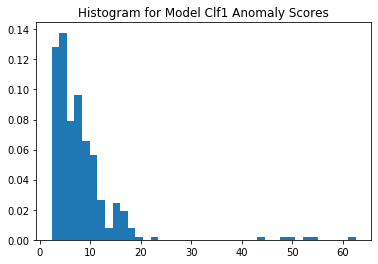

In [11]:

# Get the outlier scores for the train data
y_train_scores = clf1.decision_scores_  

# Predict the anomaly scores
y_train_pred = clf1.labels_
y_test_scores = clf1.decision_function(test_x)  # outlier scores
y_train_scores = clf1.decision_scores_  # raw outlier scores
#print(y_test_scores.shape)
y_test_scores = pd.Series(y_test_scores)
y_test_pred = clf1.predict(test_x)
 
# Plot it!
plt.close()
plt.hist(y_test_scores, bins='auto',density=True)  
plt.title("Histogram for Model Clf1 Anomaly Scores")

plt.show()

In [12]:
# evaluate and print the results
print("\nOn Training Data:")
#evaluate_print('clf_1', y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print('clf_1', test_y, y_test_scores)


On Training Data:

On Test Data:
clf_1 ROC:0.9281, precision @ rank n:0.8629


In [13]:
df_test = test_x.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<6.3, 0, 1)
print(df_test['cluster'].value_counts())

df_test.groupby('cluster').mean()

1    183
0    169
Name: cluster, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,score
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.051246,-0.115602,0.011678,-0.549257,-0.410944,-0.061401,-0.278295,0.024669,-0.287349,0.008566,...,-0.070244,0.025036,0.048608,-0.118998,0.083768,0.221448,0.102950,-0.448091,0.125238,4.293477
1,-0.090496,-0.689559,0.677958,-0.198802,0.674566,0.481160,1.793747,0.792592,0.651487,0.838603,...,-0.479786,0.156597,0.363216,0.169989,-1.254971,-1.286906,-1.164053,1.158110,-0.564696,11.739944


In [15]:
#print("Test Data Counts")
#unique, counts = np.unique(y_test, return_counts=True)
#print(dict(zip(unique, counts)))
print("Predicted Data Counts")
unique, counts = np.unique(y_test_pred, return_counts=True)
print(dict(zip(unique, counts)))

Predicted Data Counts
{0: 164, 1: 188}


In [16]:
clf2 = AutoEncoder(hidden_neurons =[20, 12, 6,  
                                    2, 
                                    6,  12, 20]
                #   ,contamination = contam
                   ,epochs=epochs
                  )
clf2.fit(clean_data)




Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 21)                462       
_________________________________________________________________
dropout_8 (Dropout)          (None, 21)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 21)                462       
_________________________________________________________________
dropout_9 (Dropout)          (None, 21)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 20)                440       
_________________________________________________________________
dropout_10 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 12)               

1489/1489 [==============================] - 0s 153us/step - loss: 2.0095 - val_loss: 1.9847
Epoch 51/100
1489/1489 [==============================] - 0s 154us/step - loss: 1.9790 - val_loss: 1.9655
Epoch 52/100
1489/1489 [==============================] - 0s 159us/step - loss: 1.9593 - val_loss: 1.9460
Epoch 53/100
1489/1489 [==============================] - 0s 154us/step - loss: 1.9243 - val_loss: 1.9268
Epoch 54/100
1489/1489 [==============================] - 0s 149us/step - loss: 1.9205 - val_loss: 1.9101
Epoch 55/100
1489/1489 [==============================] - 0s 150us/step - loss: 1.8817 - val_loss: 1.8912
Epoch 56/100
1489/1489 [==============================] - 0s 155us/step - loss: 1.8527 - val_loss: 1.8744
Epoch 57/100
1489/1489 [==============================] - 0s 155us/step - loss: 1.8447 - val_loss: 1.8582
Epoch 58/100
1489/1489 [==============================] - 0s 152us/step - loss: 1.8167 - val_loss: 1.8423
Epoch 59/100
1489/1489 [==============================] - 0

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[20, 12, 6, 2, 6, 12, 20],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x0000013614087288>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

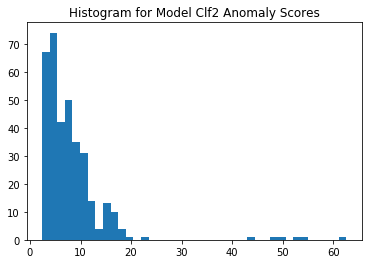

In [17]:

# Predict the anomaly scores
y_train_pred2 = clf2.labels_
y_test_scores2 = clf2.decision_function(test_x)  

y_test_scores2 = pd.Series(y_test_scores2)
y_train_scores2 = clf2.decision_scores_  # raw outlier scores
y_test_pred2 = clf2.predict(test_x)



plt.hist(y_test_scores2, bins='auto')  
plt.title("Histogram for Model Clf2 Anomaly Scores")
plt.show()

In [18]:
# evaluate and print the results
print("\nOn Training Data:")
#evaluate_print('clf_2', y_train2, y_train_scores2)
print("\nOn Test Data:")
evaluate_print('clf_2', test_y, y_test_scores2)


On Training Data:

On Test Data:
clf_2 ROC:0.9281, precision @ rank n:0.8629


In [19]:
df_test2 = test_x.copy()
df_test2['score'] = y_test_scores2
df_test2['cluster'] = np.where(df_test2['score']<6.2, 0, 1)
print(df_test2['cluster'].value_counts())

df_test2.groupby('cluster').mean()

1    186
0    166
Name: cluster, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,score
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.038060,-0.101065,0.008917,-0.541590,-0.422266,-0.061401,-0.278295,0.015659,-0.294400,-0.003552,...,-0.085423,0.016819,0.054813,-0.121067,0.078747,0.217730,0.098549,-0.448940,0.136416,4.257245
1,-0.076442,-0.693276,0.669675,-0.211297,0.667162,0.472409,1.760327,0.788247,0.642638,0.836030,...,-0.459634,0.161808,0.352604,0.167175,-1.228897,-1.259259,-1.139690,1.132961,-0.563544,11.653811


In [20]:
#print("Test Data Counts")
#unique, counts = np.unique(y_test, return_counts=True)
#print(dict(zip(unique, counts)))
print("Predicted Data Counts")
unique, counts = np.unique(y_test_pred2, return_counts=True)
print(dict(zip(unique, counts)))

Predicted Data Counts
{0: 164, 1: 188}


In [21]:
# Step 1: Build the model
clf3 = AutoEncoder(hidden_neurons =[
  #  100, 50,
    25, 1, 25
  #  , 50, 100
]
                 #  ,contamination = contam
                   ,epochs=epochs
                  )
clf3.fit(clean_data)



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 21)                462       
_________________________________________________________________
dropout_17 (Dropout)         (None, 21)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 21)                462       
_________________________________________________________________
dropout_18 (Dropout)         (None, 21)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 25)                550       
_________________________________________________________________
dropout_19 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                

1489/1489 [==============================] - 0s 119us/step - loss: 1.9270 - val_loss: 1.8214
Epoch 61/100
1489/1489 [==============================] - 0s 110us/step - loss: 1.9125 - val_loss: 1.8045
Epoch 62/100
1489/1489 [==============================] - 0s 112us/step - loss: 1.8970 - val_loss: 1.7878
Epoch 63/100
1489/1489 [==============================] - 0s 114us/step - loss: 1.8692 - val_loss: 1.7711
Epoch 64/100
1489/1489 [==============================] - 0s 115us/step - loss: 1.8463 - val_loss: 1.7547
Epoch 65/100
1489/1489 [==============================] - 0s 119us/step - loss: 1.8325 - val_loss: 1.7393
Epoch 66/100
1489/1489 [==============================] - 0s 115us/step - loss: 1.8139 - val_loss: 1.7247
Epoch 67/100
1489/1489 [==============================] - 0s 117us/step - loss: 1.7899 - val_loss: 1.7098
Epoch 68/100
1489/1489 [==============================] - 0s 113us/step - loss: 1.7710 - val_loss: 1.6946
Epoch 69/100
1489/1489 [==============================] - 0

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 1, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x0000013614087288>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

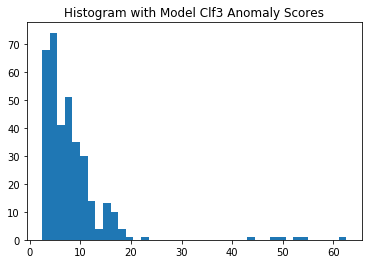

In [22]:

# Predict the anomaly scores
y_train_pred3 = clf3.labels_
y_test_scores3 = clf3.decision_function(test_x)
#print(y_test_scores.shape)
y_test_scores3 = pd.Series(y_test_scores3)
y_train_scores3 = clf3.decision_scores_  # raw outlier scores
y_test_pred3 = clf3.predict(test_x)


# Step 2: Determine the cut point
plt.hist(y_test_scores3, bins='auto')  
plt.title("Histogram with Model Clf3 Anomaly Scores")
plt.show()

In [23]:
# evaluate and print the results
#print("\nOn Training Data:")
#evaluate_print('clf_3', y_train3, y_train_scores3)
print("\nOn Test Data:")
evaluate_print('clf_3', test_y, y_test_scores3)


On Test Data:
clf_3 ROC:0.9284, precision @ rank n:0.8629


In [24]:
#print("Test Data Counts")
#unique, counts = np.unique(y_test3, return_counts=True)
#print(dict(zip(unique, counts)))
print("Predicted Data Counts")
unique, counts = np.unique(y_test_pred3, return_counts=True)
print(dict(zip(unique, counts)))

Predicted Data Counts
{0: 164, 1: 188}


In [25]:
df_test3 = test_x.copy()
df_test3['score'] = y_test_scores3
df_test3['cluster'] = np.where(df_test3['score']<6.2, 0, 1)
print(df_test3['cluster'].value_counts())

df_test3.groupby('cluster').mean()

1    186
0    166
Name: cluster, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,score
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.038060,-0.101065,0.008917,-0.541590,-0.422266,-0.061401,-0.278295,0.015659,-0.294400,-0.003552,...,-0.085423,0.016819,0.054813,-0.121067,0.078747,0.217730,0.098549,-0.448940,0.136416,4.260661
1,-0.076442,-0.693276,0.669675,-0.211297,0.667162,0.472409,1.760327,0.788247,0.642638,0.836030,...,-0.459634,0.161808,0.352604,0.167175,-1.228897,-1.259259,-1.139690,1.132961,-0.563544,11.652077


In [26]:
# Put all the predictions in a data frame
from pyod.models.combination import aom, moa, average, maximization

# Put all the predictions in a data frame
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

test_scores  = pd.DataFrame({'clf1': clf1.decision_function(test_x),
                             'clf2': clf2.decision_function(test_x),
                             'clf3': clf3.decision_function(test_x) 
                            })
    

In [27]:
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

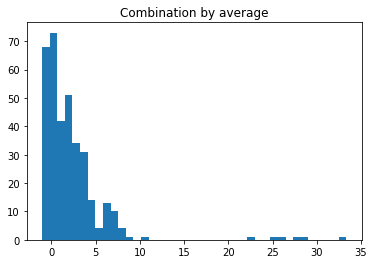

In [28]:
# Combination by average
y_by_average = average(test_scores_norm)
  

  
plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [29]:


# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# x, y = np.random.rand(2, 100) * 4

# hist, xedges, yedges = np.histogram2d(x_test[0], y_by_maximization, bins=10, range=[[-2, 2.5], [-2, 2.5]])

# # Construct arrays for the anchor positions of the 16 bars.
# xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
# xpos = xpos.ravel()
# ypos = ypos.ravel()
# zpos = 0

# # Construct arrays with the dimensions for the 16 bars.
# dx = dy = 0.5 * np.ones_like(zpos)
# dz = hist.ravel()

# ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
# ax.view_init(azim=-220,elev=36)
# plt.show()

In [31]:
df_test = pd.DataFrame(test_x)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<0.8, 0, 1)
print(df_test['y_by_average_cluster'].value_counts())



df_test.groupby('y_by_average_cluster').mean()

1    201
0    151
Name: y_by_average_cluster, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,y_by_average_score
y_by_average_cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.074275,-0.077874,-0.033992,-0.591799,-0.464675,-0.061401,-0.278295,-0.002669,-0.313149,-0.033443,...,-0.104046,-0.045188,0.032580,-0.123036,0.020792,0.161824,0.034188,-0.461654,0.112437,-0.082073
1,0.016494,-0.666503,0.652601,-0.198226,0.617721,0.432572,1.608191,0.744360,0.586795,0.795830,...,-0.417717,0.197571,0.347084,0.147143,-1.087774,-1.107037,-0.998933,1.024459,-0.493294,3.988343


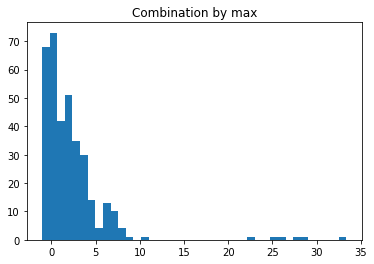

0    313
1     39
Name: y_by_maximization_cluster, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,y_by_average_score,y_by_average_cluster,y_by_maximization_score
y_by_maximization_cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.007934,-0.386839,0.216292,-0.393583,0.064271,-0.061401,0.402955,0.406558,0.124881,0.547319,...,0.125855,-0.057044,-0.326388,-0.371728,-0.361665,-0.021943,-0.086271,1.274758,0.517572,1.276558
1,-0.138890,-0.631936,1.495910,-0.154195,0.868692,2.484460,3.976899,0.563098,0.809555,-0.420487,...,0.904893,0.739796,-2.906241,-2.095595,-2.113389,3.668582,-1.414649,10.006784,1.000000,10.011691


In [33]:
# Combination by max
y_by_maximization = maximization(test_scores_norm)
             

plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

df_test = pd.DataFrame(test_x)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<5, 0, 1)
print(df_test['y_by_maximization_cluster'].value_counts())

df_test.groupby('y_by_maximization_cluster').mean()

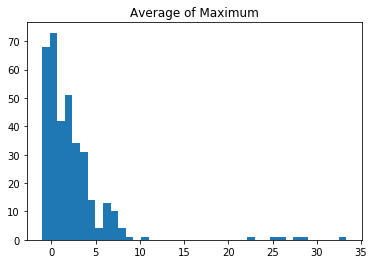

1    220
0    132
Name: y_by_aom_cluster, dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,y_by_average_score,y_by_average_cluster,y_by_maximization_score,y_by_maximization_cluster,y_by_aom_score
y_by_aom_cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.169044,-0.032391,-0.027043,-0.538326,-0.455024,-0.061401,-0.278295,-0.179282,-0.264812,-0.136634,...,-0.020974,0.114271,-0.013545,-0.461089,0.162505,-0.186212,0.000000,-0.184254,0.000000,-0.186418
1,0.065517,-0.642957,0.589134,-0.264301,0.518450,0.389911,1.445267,0.785812,0.480070,0.786125,...,-0.966974,-0.968922,-0.881069,0.895774,-0.471022,3.699290,0.913636,3.701546,0.177273,3.698927


In [34]:
# Combination by aom
y_by_aom = median(test_scores_norm)


plt.hist(y_by_aom, bins='auto')  # arguments are passed to np.histogram
plt.title("Average of Maximum")
plt.show()

df_test = pd.DataFrame(test_x)
df_test['y_by_aom_score'] = y_by_aom
df_test['y_by_aom_cluster'] = np.where(df_test['y_by_aom_score']<0.5, 0, 1)
print(df_test['y_by_aom_cluster'].value_counts())


df_test.groupby('y_by_aom_cluster').mean()

In [36]:
unique, counts = np.unique(y_test_pred, return_counts=True)
dict(zip(unique, counts))

{0: 663, 1: 70}

In [37]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0.0: 663, 1.0: 70}